In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
from sklearn.utils import shuffle


data_segments = ["train", "val"] 

data_dir = "../data/hymenoptera_data/"
img_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                for x in data_segments}
dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in data_segments}

dataset_sizes = {x: len(img_datasets[x]) for x in data_segments}
class_names = img_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
from cProfile import label
from pickletools import optimize


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print(f">>> Epoch {epoch+1} / {num_epochs}")
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    out = model(inputs)
                    _, preds = torch.max(out, 1)
                    loss = criterion(out, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == True:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model
                

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

>>> Epoch 1 / 25
----------
train Loss: 0.5386 Acc: 0.7090
val Loss: 0.4151 Acc: 0.7974

>>> Epoch 2 / 25
----------
train Loss: 0.5833 Acc: 0.7418
val Loss: 0.3163 Acc: 0.9085

>>> Epoch 3 / 25
----------
train Loss: 0.3923 Acc: 0.8279
val Loss: 0.3302 Acc: 0.8824

>>> Epoch 4 / 25
----------
train Loss: 0.4406 Acc: 0.8156
val Loss: 0.5135 Acc: 0.8431

>>> Epoch 5 / 25
----------
train Loss: 0.7908 Acc: 0.7541
val Loss: 0.7704 Acc: 0.7255

>>> Epoch 6 / 25
----------
train Loss: 0.4765 Acc: 0.8320
val Loss: 0.2899 Acc: 0.9020

>>> Epoch 7 / 25
----------
train Loss: 0.5061 Acc: 0.8197
val Loss: 0.1846 Acc: 0.9346

>>> Epoch 8 / 25
----------
train Loss: 0.4566 Acc: 0.8197
val Loss: 0.2088 Acc: 0.9412

>>> Epoch 9 / 25
----------
train Loss: 0.5103 Acc: 0.7828
val Loss: 0.2662 Acc: 0.9020

>>> Epoch 10 / 25
----------
train Loss: 0.3638 Acc: 0.8484
val Loss: 0.3032 Acc: 0.9085

>>> Epoch 11 / 25
----------
train Loss: 0.3315 Acc: 0.8525
val Loss: 0.4964 Acc: 0.8627

>>> Epoch 12 / 25
-

TypeError: Invalid shape (3, 224, 224) for image data

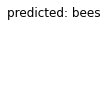

In [16]:
visualize_model(model_ft)